Consider the case in which all the users belong to class C1, and no information about the advertising and pricing curves is known beforehand. Apply the GP-UCB and GP-TS algorithms when using GPs to model the two advertising curves, reporting the plots of the average (over a sufficiently large number of runs) value and standard deviation of the cumulative regret, cumulative reward, instantaneous regret, and instantaneous reward.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import deque

from utils.User_Classes import UserClass
from utils.Clairvoyant import find_optimal_bid_for_class
from utils.tools import calculate_margin, calculate_price_index, fun
from utils.learners.TS_Learner import TS_Learner
#from p3.bidding_enviroment import BiddingEnvironment, fun
from utils.tools import fun
#from p3.GPTS_learner import  GPTS_Learner3

import warnings
warnings.filterwarnings("ignore")

# Environment

In [2]:
#TODO: move to p3
class Princing_Environment_3(): #m
    def __init__(self, n_arms, user_class):
        self.user_class = user_class
        self.time = 0
        self.n_arms = n_arms

    def round(self, user_class, price_idx, n):
        successes = np.random.binomial(n, user_class.get_conversion_probabilities()[price_idx]) # Number of samples n
        return successes

In [3]:
class Bidding_Environment_3:
    def __init__(self, bids, clicks_sigma, cost_sigma, user_class, n_arms):
        self.bids = bids
        self.clicks_means = self.initialize_clicks(user_class=user_class, bids=bids)
        self.cost_means = self.initialize_cost(user_class=user_class, bids=bids)
        self.clicks_sigmas = np.ones(len(bids)) * clicks_sigma
        self.cost_sigmas = np.ones(len(bids)) * cost_sigma
        self.n_arms = n_arms

    #TODO: probabily remove
    def initialize_means(self, user_class, bids, price):
        means = np.zeros(len(bids))
        for i in range(len(means)):
                means[i] = fun(user_class, bids[i], price)
        return means
    
    def initialize_clicks(self, user_class, bids):
        means = np.zeros(len(bids))
        for j, b in enumerate(bids):
            means[j] = user_class.get_click_bids(b)
        return means

    def initialize_cost(self, user_class, bids):
        means = np.zeros(len(bids))
        for j, b in enumerate(bids):
            means[j] = user_class.get_cost_per_click(b)
        return means

    def round(self, pulled_arm):
        sample_clicks = np.random.normal(self.clicks_means[pulled_arm], self.clicks_sigmas[pulled_arm])
        sample_cost = np.random.normal(self.cost_means[pulled_arm], self.cost_sigmas[pulled_arm])
        #Handle the exceptions
        if sample_cost > self.bids[pulled_arm]:
            sample_cost = self.bids[pulled_arm]
        if sample_cost < 0:
            sample_cost = 0
        if int(sample_clicks) < 0:
            sample_clicks = self.clicks_means[pulled_arm]

        return int(sample_clicks), sample_cost

In [4]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
import numpy as np
from utils.learners.Learner import Learner

#This learner consider the clicks and the cost
class GPTS_Learner3(Learner):
    def __init__(self, n_arms, arms):
        super().__init__(n_arms)
        self.arms = arms
        self.clicks_means = np.zeros(self.n_arms)
        self.clicks_sigmas = np.ones(self.n_arms)
        self.cost_means = np.zeros(self.n_arms)
        self.cost_sigmas = np.ones(self.n_arms)
        self.pulled_arms = []
        self.collected_clicks = []
        self.collected_costs = []
        alpha_clicks = 1000
        kernel_clicks = C(100, (100, 1e6)) * RBF(10, (1e-1, 1e6))
        self.gp_clicks = GaussianProcessRegressor(kernel=kernel_clicks, alpha=alpha_clicks, normalize_y=False, n_restarts_optimizer=1)

        alpha_cost = 0.3
        kernel_cost = C(0.1, (1, 1e2)) * RBF(0.1, (1, 1e2))
        self.gp_cost = GaussianProcessRegressor(kernel=kernel_cost, alpha=alpha_cost, normalize_y=False, n_restarts_optimizer=1)

    def update_observations_gpts(self, pulled_arm, clicks, costs):
        # self.rewards_per_arm[pulled_arm].append(reward)
        self.collected_clicks = np.append(self.collected_clicks, clicks)
        self.collected_costs = np.append(self.collected_costs, costs)
        self.pulled_arms.append(self.arms[pulled_arm])

    def update_model(self):
        x = np.atleast_2d(self.pulled_arms).T
        y = self.collected_clicks
        self.gp_clicks.fit(x, y)
        self.clicks_means, self.clicks_sigmas = self.gp_clicks.predict(np.atleast_2d(self.arms).T, return_std=True)
        self.clicks_sigmas = np.maximum(self.clicks_sigmas, 30)

        x = np.atleast_2d(self.pulled_arms).T
        y = self.collected_costs
        self.gp_cost.fit(x, y)
        self.cost_means, self.cost_sigmas = self.gp_cost.predict(np.atleast_2d(self.arms).T, return_std=True)
        self.cost_sigmas = np.maximum(self.cost_sigmas, 0.01)

    def update(self, pulled_arm, clicks, costs):
        self.t += 1
        self.update_observations_gpts(pulled_arm, clicks, costs)
        self.update_model()

    def pull_arm(self, conv_rate, margin):
        """
        if self.t < self.n_arms:
            return self.t  # % self.n_arms
        try:
            conv_rate = pricing_learner.beta_parameters[price_idx, 0] / (pricing_learner.beta_parameters[price_idx, 0]
                                                                         + pricing_learner.beta_parameters[
                                                                             price_idx, 1])
        except ZeroDivisionError:
            conv_rate = 0
            print('DIV 0')
        #poisson = pricing_learner.poisson_vector[price_idx, 0] + 1
        """
        
        exp_rew = np.random.normal(self.clicks_means * (np.ones(shape=self.n_arms) * margin * conv_rate - self.cost_means), 50) #TODO: check if a variance of 50 is ok
        #Probabily change in self.clicks_means * (np.ones(shape=self.n_arms) in self.means

        bid_idx = np.argmax(exp_rew)

        return bid_idx

In [26]:
from utils.learners.Learner import *
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

class GPUCB_Learner3(Learner):
    def __init__(self, n_arms, arms):
        super().__init__(n_arms)
        self.arms = arms
        self.empirical_clicks_means = np.zeros(n_arms)
        self.clicks_confidence = np.array([np.inf] * n_arms)
        self.empirical_costs_means = np.zeros(n_arms)
        self.costs_confidence = np.array([np.inf] * n_arms)
        self.pulled_arms = []
        self.collected_clicks = [[] for i in range(n_arms)]
        self.collected_costs = [[] for i in range(n_arms)]

        alpha_clicks = 1000
        kernel_clicks = C(100, (100, 1e6)) * RBF(1, (1e-1, 1e1))
        self.gp_clicks = GaussianProcessRegressor(kernel=kernel_clicks, alpha=alpha_clicks ** 2, normalize_y=True, n_restarts_optimizer=9)

        alpha_cost = 0.3
        kernel_cost = C(0.1, (1, 1e2)) * RBF(0.1, (1, 1e2))
        self.gp_costs = GaussianProcessRegressor(kernel=kernel_cost, alpha=alpha_cost, normalize_y=False, n_restarts_optimizer=1)

    def update_observations(self, pulled_arm, clicks, costs):
        self.collected_clicks = np.append(self.collected_clicks, clicks)
        self.collected_costs = np.append(self.collected_costs, costs)
        self.pulled_arms.append(self.arms[pulled_arm])


    def update_model(self):
        x = np.atleast_2d(self.pulled_arms).T
        y = self.collected_clicks
        self.gp_clicks.fit(x,y)
        self.clicks_means, self.clicks_sigmas = self.gp_clicks.predict(np.atleast_2d(self.arms).T, return_std=True)
        self.clicks_sigmas = np.maximum(self.clicks_sigmas, 1e-2)

        x = np.atleast_2d(self.pulled_arms).T
        y = self.collected_costs
        self.gp_costs.fit(x,y)
        self.costs_means, self.costs_sigmas = self.gp_costs.predict(np.atleast_2d(self.arms).T, return_std=True)
        self.costs_sigmas = np.maximum(self.costs_sigmas, 1e-2)

    def pull_arm(self, conv_rate, margin):
        upper_conf_clicks = self.empirical_clicks_means + self.clicks_confidence
        lower_conf_costs = self.empirical_costs_means - self.costs_confidence

        sampled_reward = conv_rate * upper_conf_clicks * margin - lower_conf_costs
        
        return np.random.choice(np.where(sampled_reward == sampled_reward.max())[0])

    def update(self, pull_arm, clicks, costs):
        self.t += 1
        self.empirical_clicks_means[pull_arm] = (self.empirical_clicks_means[pull_arm] * (self.t - 1) + clicks) / self.t
        for a in range(self.n_arms):
            n_samples = len(self.collected_clicks[a])
            self.clicks_confidence[a] = (2 * np.log(self.t) / n_samples) ** 0.5 if n_samples > 0 else np.inf
        
        self.empirical_costs_means[pull_arm] = (self.empirical_costs_means[pull_arm] * (self.t - 1) + costs) / self.t
        for a in range(self.n_arms):
            n_samples = len(self.collected_costs[a])
            self.costs_confidence[a] = (2 * np.log(self.t) / n_samples) ** 0.5 if n_samples > 0 else np.inf
        

        self.update_observations(pull_arm, clicks, costs)
        self.update_model()


In [6]:
#Environment
n_arms = 100

prices = [50, 100, 150, 200, 250]
bids = np.linspace(0.01, 3.0, n_arms)
clicks_sigma = 50
cost_sigma = 10

user = UserClass(name='C1')

T = 20
n_experiments = 20

gpts_rewards_per_experiment = []
gpucb_rewards_per_experiment = []

opt_vec = []
for price_index in range(len(prices)):
    opt_vec.append(find_optimal_bid_for_class(user.user_index, price_index))

print(opt_vec) # reward of optimum bid
optimum_bid_reward = np.max(np.array(opt_vec))
print(optimum_bid_reward) #optimum bid

[(1.1576767676767679, 6127.368234858888), (1.2482828282828284, 9619.200566683632), (1.308686868686869, 12414.766949004006), (1.338888888888889, 13812.946373355671), (1.338888888888889, 13812.946373355671)]
13812.946373355671


In [7]:
# Create Environment
pr_env = Princing_Environment_3(n_arms, user)
bid_env = Bidding_Environment_3(bids, clicks_sigma, cost_sigma, user, n_arms)

In [8]:
for e in tqdm(range(n_experiments), desc='Number of experiments'):
    # Create Learner
    pricing_learner = TS_Learner(len(prices))
    bidding_GPTS_learner = GPTS_Learner3(n_arms, arms=bids)
    ts_rewards = []

    # generate empty deque
    arms = []

    # Simulate experiments
    for d in range(T):
        # choose arms
        pricing_pulled_arm = pricing_learner.pull_arm()
        arms.append(pricing_pulled_arm)
        #Calculate the conversion rate of the price choose
        conv_rate =pricing_learner.beta_parameters[pricing_pulled_arm, 0] / (pricing_learner.beta_parameters[pricing_pulled_arm, 0]
            + pricing_learner.beta_parameters[pricing_pulled_arm, 1])

        #GPTS
        # Fixed the price, I can find the bid that maximize the expected reward
        bidding_pulled_arm = bidding_GPTS_learner.pull_arm(conv_rate=conv_rate, margin=calculate_margin(prices[pricing_pulled_arm]))
        # empty daily reward
        n_clicks, costperclick = bid_env.round(pulled_arm=bidding_pulled_arm)
        # how many successes?
        ts_successes = pr_env.round(user, pricing_pulled_arm, n_clicks)
        # update beta
        pricing_learner.update(pricing_pulled_arm, ts_successes)
        # Reward of the day
        daily_reward = ts_successes * calculate_margin(prices[pricing_pulled_arm]) - costperclick * n_clicks
        costs = costperclick * n_clicks
        bidding_GPTS_learner.update(pulled_arm=bidding_pulled_arm, costs=costs, clicks=n_clicks)
        # save daily reward
        ts_rewards.append(daily_reward)
        
    gpts_rewards_per_experiment.append(ts_rewards)
    



Number of experiments: 100%|██████████| 20/20 [00:13<00:00,  1.48it/s]


In [27]:
for e in tqdm(range(n_experiments), desc='Number of experiments'):
    # Create Learner
    pricing_learner = TS_Learner(len(prices))
    bidding_GPUCB_learner = GPUCB_Learner3(n_arms, arms=bids)
    ucb_rewards = []

    print('arms:', bidding_GPUCB_learner.n_arms)
    # generate empty deque
    arms = []

    # Simulate experiments
    for d in range(T):
        # choose arms
        pricing_pulled_arm = pricing_learner.pull_arm()
        arms.append(pricing_pulled_arm)
        #Calculate the conversion rate of the price choose
        conv_rate =pricing_learner.beta_parameters[pricing_pulled_arm, 0] / (pricing_learner.beta_parameters[pricing_pulled_arm, 0]
            + pricing_learner.beta_parameters[pricing_pulled_arm, 1])

        #GPUCB
        # Fixed the price, I can find the bid that maximize the expected reward
        bidding_pulled_arm = bidding_GPUCB_learner.pull_arm(conv_rate=conv_rate, margin=calculate_margin(prices[pricing_pulled_arm]))
        # empty daily reward
        n_clicks, costperclick = bid_env.round(pulled_arm=bidding_pulled_arm)
        # how many successes?
        ucb_successes = pr_env.round(user, pricing_pulled_arm, n_clicks)
        # update beta
        pricing_learner.update(pricing_pulled_arm, ucb_successes)
        # Reward of the day
        daily_reward = ucb_successes * calculate_margin(prices[pricing_pulled_arm]) - costperclick * n_clicks
        costs = costperclick * n_clicks
        bidding_GPUCB_learner.update(pull_arm=bidding_pulled_arm, costs=costs, clicks=n_clicks)
        # save daily reward
        ucb_rewards.append(daily_reward)
        
    gpucb_rewards_per_experiment.append(ucb_rewards)

Number of experiments:   0%|          | 0/20 [00:00<?, ?it/s]

arms: 100


IndexError: list index out of range

# Cumulative Regret

## TS & GPTS

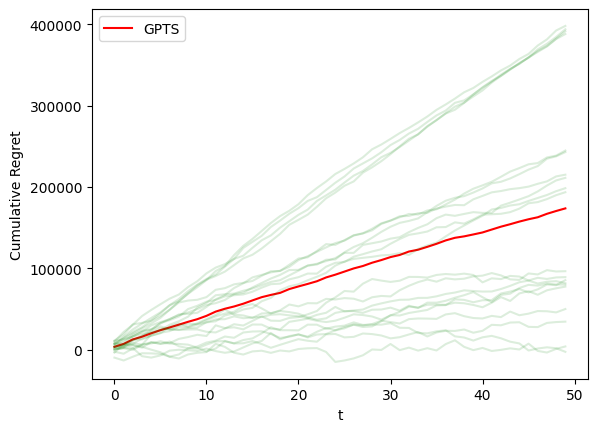

In [ ]:
plt.figure(0)
plt.ylabel("Cumulative Regret")
plt.xlabel("t")
plt.plot(np.cumsum(np.mean(optimum_bid_reward - gpts_rewards_per_experiment, axis=0)), 'r', label='GPTS')
for index, line in enumerate(gpts_rewards_per_experiment):
        plt.plot(np.nancumsum(optimum_bid_reward- line, axis=0), "g", alpha=1 / np.power(len(gpts_rewards_per_experiment), 2/3))
plt.legend()
plt.show()

## TS & GPUCB

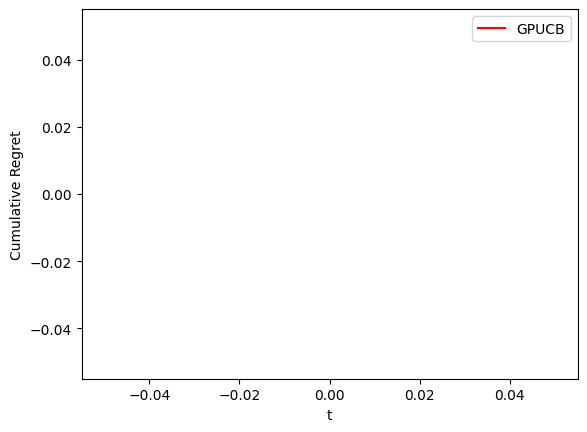

In [ ]:
plt.figure(0)
plt.ylabel("Cumulative Regret")
plt.xlabel("t")
plt.plot(np.cumsum(np.mean(optimum_bid_reward - gpucb_rewards_per_experiment, axis=0)), 'r', label='GPUCB')
for index, line in enumerate(gpucb_rewards_per_experiment):
        plt.plot(np.nancumsum(optimum_bid_reward - line, axis=0), "g", alpha=1 / np.power(len(gpts_rewards_per_experiment), 2/3))
plt.legend()
plt.show()

# Cumulative Reward

## TS & GPTS

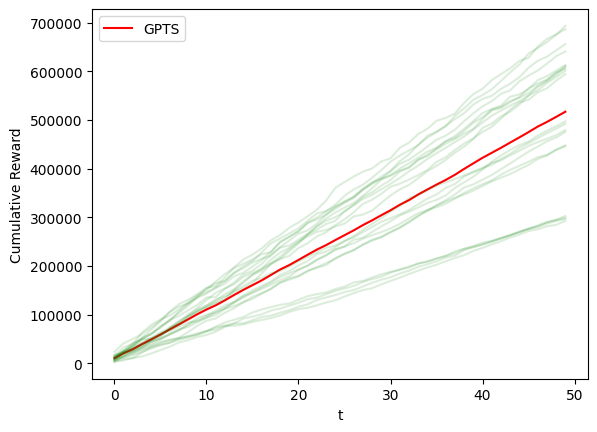

In [ ]:
plt.figure(0)
plt.ylabel("Cumulative Reward")
plt.xlabel("t")
plt.plot(np.cumsum(np.mean(gpts_rewards_per_experiment, axis=0)), 'r', label='GPTS')
for index, line in enumerate(gpts_rewards_per_experiment):
        plt.plot(np.nancumsum(line, axis=0), "g", alpha=1 / np.power(len(gpts_rewards_per_experiment), 2/3))
plt.legend()
plt.show()

## TS & GPUCB

# Istantaneous Regret

## TS & GPTS

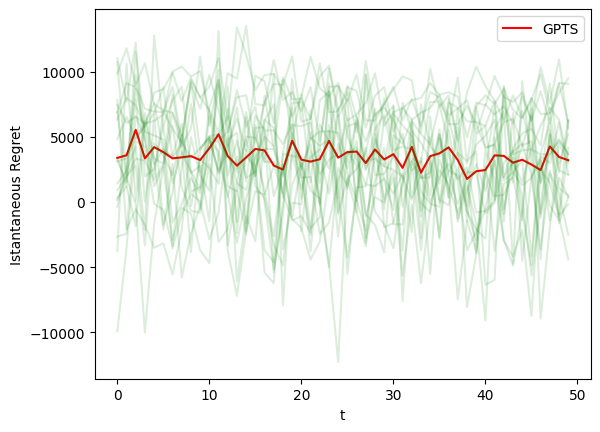

In [ ]:
plt.figure(0)
plt.ylabel("Istantaneous Regret")
plt.xlabel("t")
plt.plot(np.mean(optimum_bid_reward - gpts_rewards_per_experiment, axis=0), 'r', label='GPTS')
for index, line in enumerate(gpts_rewards_per_experiment):
        plt.plot(optimum_bid_reward - line, "g",  alpha=1 / np.power(len(gpts_rewards_per_experiment) , 2/3))
plt.legend()
plt.show()

## TS & GPUCB

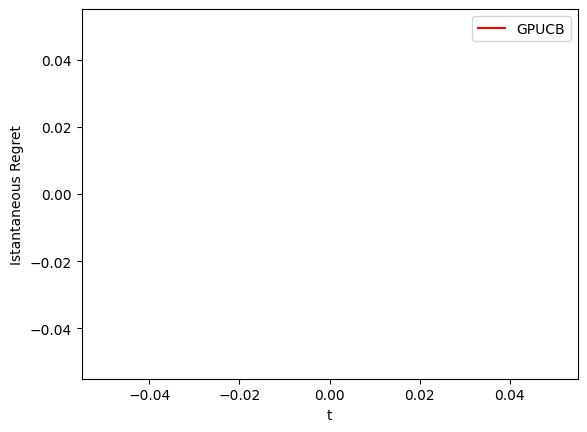

In [ ]:
plt.figure(0)
plt.ylabel("Istantaneous Regret")
plt.xlabel("t")
plt.plot(np.mean(optimum_bid_reward - gpucb_rewards_per_experiment, axis=0), 'r', label='GPUCB')
for index, line in enumerate(gpucb_rewards_per_experiment):
        plt.plot(optimum_bid_reward - line, "g",  alpha=1 / np.power(len(gpucb_rewards_per_experiment) , 2/3))
plt.legend()
plt.show()

# Instantaneous Reward

## TS & GPTS

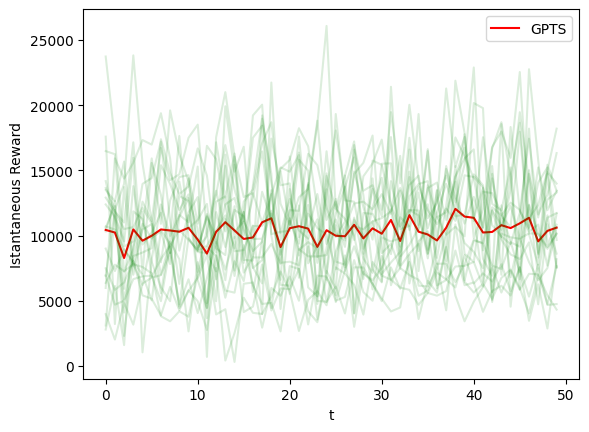

In [ ]:
plt.figure(0)
plt.ylabel("Istantaneous Reward")
plt.xlabel("t")
plt.plot(np.mean(gpts_rewards_per_experiment, axis=0), 'r', label='GPTS')
for line in gpts_rewards_per_experiment:
    plt.plot(line, "g", alpha=1 / np.power(len(gpts_rewards_per_experiment), 2/3))
plt.legend()
plt.show()

## TS & GPUCB

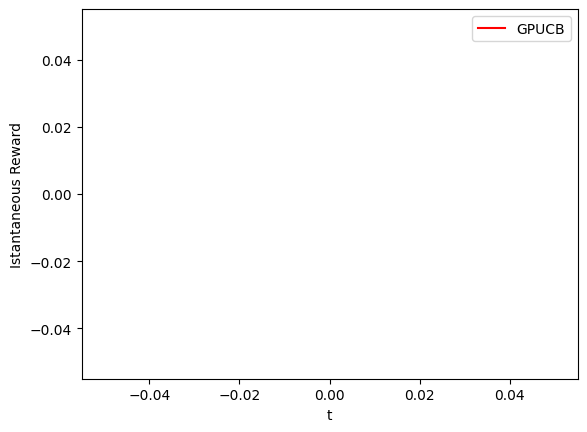

In [ ]:
plt.figure(0)
plt.ylabel("Istantaneous Reward")
plt.xlabel("t")
plt.plot(np.mean(gpucb_rewards_per_experiment, axis=0), 'r', label='GPUCB')
for line in gpucb_rewards_per_experiment:
    plt.plot(line, "g", alpha=1 / np.power(len(gpucb_rewards_per_experiment), 2/3))
plt.legend()
plt.show()

# Test

In [ ]:
from p1.pricing_environment import *

In [ ]:
n_arms = 5

env = Environment_Pricing_2(n_arms=n_arms, p = p)
prices = env.prices

T = 365 #time steps for each experiment

n_experiments = 1000

ts_rewards_per_experiment = [] #list to store the collected rewards for TS_Learner over each experiment
pulled_arm_number = [0 for i in range(0,5)]
# Loop over the experiments
for e in tqdm(range(0, n_experiments)):
    env_pr = Environment_Pricing_2(n_arms=n_arms, p = p)
    ts_learner = TS_Learner(n_arms=n_arms)
    for t in range(0,T):
        #Thompson sampling
        pulled_arm = ts_learner.pull_arm()
        reward = env_pr.round(class_index=0, price_index=pulled_arm, bid=1)
        #print(reward)
        ts_learner.update(pulled_arm, reward/34627)
        ts_learner.update_observations(pulled_arm, reward)
        pulled_arm_number[pulled_arm] += 1


    ts_rewards_per_experiment.append(ts_learner.collected_rewards)

# Compute the mean and standard deviation of the cumulative reward at each round
mean_cum_reward_ts = np.mean(ts_rewards_per_experiment, axis=0)
#std_cum_reward_ts = np.std(ts_rewards_per_experiment, axis=0)

reward_ts = mean_cum_reward_ts

#std_cum_reward_ucb = np.std(ucb_reward_per_experiment, axis=0)

NameError: name 'Environment_Pricing_2' is not defined

# Trash

In [ ]:
class Pricing_Environment():
    def __init__(self, n_arms, probabilities, prices=None):
        self.n_arms = n_arms
        self.probabilities = probabilities
        self.prices = prices

    def round(self, pulled_arm, user_c, n_trials=1):
        successes = np.random.binomial(n_trials, self.probabilities[user_c.index][pulled_arm])
        number_returns = np.random.poisson(successes * self.poissons[user_c.index])
        marg = self.margins[pulled_arm] * (number_returns + successes)
        return successes, number_returns

In [ ]:
class Bidding_Enviroment():
    def __init__(self, bids, acc_sigma, cost_sigma, user_classes, n_arms):
        self.bids = bids
        self.acc_means = self.initialize_accesses(user_classes=user_classes, bids=bids)
        self.cost_means = self.initialize_cost(user_classes=user_classes, bids=bids)
        self.acc_sigmas = np.ones(len(bids)) * acc_sigma
        self.cost_sigmas = np.ones(len(bids)) * cost_sigma
        self.n_arms = n_arms

    def initialize_accesses(self, user_classes, bids):
        means = np.zeros(shape=(len(user_classes), len(bids)))
        for ii, c in enumerate(user_classes):
            for j, b in enumerate(bids):
                means[ii, j] = c.clicks(b)
        return means

    def initialize_cost(self, user_classes, bids):
        means = np.zeros(shape=(len(user_classes), len(bids)))
        for ii, c in enumerate(user_classes):
            for j, b in enumerate(bids):
                means[ii, j] = cost_per_click(b)
        return means

    def round(self, pulled_arm, user_c):
        sample_accesses = np.random.normal(self.acc_means[user_c, pulled_arm], self.acc_sigmas[pulled_arm])
        sample_cost = np.random.normal(self.cost_means[user_c, pulled_arm], self.cost_sigmas[pulled_arm])
        if sample_cost > self.bids[pulled_arm]:
            sample_cost = self.bids[pulled_arm]
        if sample_cost < 0:
            sample_cost = 0
        if int(sample_accesses) < 0:
            sample_accesses = self.acc_means[user_c, pulled_arm]

        return int(sample_accesses), sample_cost

In [ ]:
def fun(user_class, bid, price):
    mean_per_bid = user_class.get_click_bids(bid) * (user_class.get_conversion_per_price(price) * calculate_margin(price)) - user_class.get_click_bids(bid) * user_class.get_cost_per_click(bid)    #sample_cost
    return mean_per_bid

class BiddingEnvironment:
    def __init__(self, bids, sigma, user_class, price, n_arms):
        self.bids = bids
        self.means = self.initialize_means(user_class=user_class, bids=bids, price=price)
        self.sigmas = np.ones(len(bids)) * sigma
        self.price = price
        self.n_arms = n_arms

    def initialize_means(self, user_class, bids, price):
        means = np.zeros(len(bids))
        for i in range(len(means)):
                means[i] = fun(user_class, bids[i], price)
        return means

    def round(self, pulled_arm):
        return np.random.normal(self.means[pulled_arm], self.sigmas[pulled_arm])